### Исследовательский проект 
“Предсказание рейтингов фильмов на основе компьютерного анализа биологических сигналов респондентов” 

# Линейная регрессия 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import shap
import seaborn as sns
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
from sklearn.preprocessing import QuantileTransformer

In [3]:
data = pd.read_csv("/Users/apple/Desktop/lab_dataset_filtered.csv")
data.head()

,Theta,Alpha,Beta,TotalAbsPow,Theta_watch-relax,Alpha_watch-relax,Beta_watch-relax,Beta/Alpha,Beta/(Alpha + Theta),ApEn,...,ShanEn,SpEn,WPEn,ch,film,Subj,labels,Theta_ratio,Alpha_ratio,Beta_ratio
0,0.306417,0.051499,0.047905,0.166229,0.552600,0.766122,0.931168,0.268510,0.723673,0.657834,...,0.416636,0.656087,0.999443,1,1,1,10,0.526244,0.203860,0.269896
1,0.130892,0.027491,0.035651,0.080043,0.486594,0.764210,0.931905,0.268885,0.724264,0.757770,...,0.416455,0.746751,0.999079,2,1,1,10,0.421152,0.211133,0.367715
2,0.074232,0.017666,0.039045,0.057475,0.495192,0.753900,0.932780,0.256988,0.693936,0.640169,...,0.416334,0.565815,0.999200,3,1,1,10,0.348217,0.193641,0.458142
3,0.199833,0.055224,0.058346,0.142365,0.513512,0.772845,0.935005,0.268511,0.723786,0.660308,...,0.415972,0.548588,1.000000,4,1,1,10,0.414250,0.247133,0.338618
4,0.291537,0.086981,0.056585,0.196472,0.511219,0.783938,0.929024,0.267723,0.723650,0.595585,...,0.416575,0.674397,0.998649,6,1,1,10,0.455908,0.279164,0.264928


##### Посмотрим на размер данных

In [4]:
data.shape

(1576, 39)

##### Посмотрим на значение столбцов

In [5]:
data.columns

Index(['Theta', 'Alpha', 'Beta', 'TotalAbsPow', 'Theta_watch-relax',
       'Alpha_watch-relax', 'Beta_watch-relax', 'Beta/Alpha',
       'Beta/(Alpha + Theta)', 'ApEn', 'CREn', 'DiffEn', 'FI', 'Hjorth',
       'Hurst', 'KFD', 'LZC', 'MSE', 'MSPEn', 'NLD', 'PEn', 'PFD', 'PLZC',
       'PSDslope', 'RR', 'SDA', 'SFD', 'SVDEn', 'SampEn', 'ShanEn', 'SpEn',
       'WPEn', 'ch', 'film', 'Subj', 'labels', 'Theta_ratio', 'Alpha_ratio',
       'Beta_ratio'],
      dtype='object')

Уберем факторы, которые не несут в себе смысл для нахождения закономерности, например каналы: "film", "ch", "Subj".

А так же вынесем главный признак, который мы собственное и ходим угадывать - канал "labels".
Теперь обучающая матрица будет находится в переменной X


In [6]:
X_test = data.loc[(data['Subj']  == 11)].reset_index(drop=True)
X_train = data.loc[(data['Subj'] != 11)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'labels', 'Subj'], axis=1)
X_test = X_test.drop(['film', 'labels', 'Subj'], axis=1)


qt_train = QuantileTransformer(output_distribution='normal',
                           copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

In [7]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [8]:
y_pred = model.predict(X_test)

In [9]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x126c35d60>]],
      dtype=object)

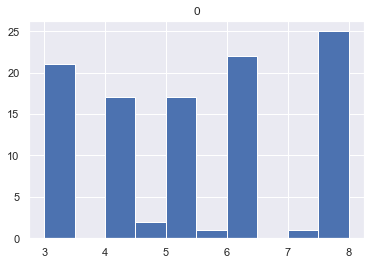

In [10]:
pd.DataFrame(preds).hist()

In [11]:
pd.DataFrame(preds).describe()

,0
count,106.000000
mean,5.383212
std,1.792040
min,3.000000
25%,4.000000
50%,5.000000
75%,6.139815
max,8.000000


In [12]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(12)]
num_chans = [[0 for j in range(8)] for i in range(12)]
labels = [[0 for j in range(8)] for i in range(12)]
lbl = [[0 for j in range(8)] for i in range(12)]
channels = [[] for i in range(12)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
    labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [13]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 8.00 predicted: 6.81 
label : 3.00 predicted: 4.84 
label : 5.00 predicted: 3.89 
label : 8.00 predicted: 6.16 
label : 6.00 predicted: 5.64 
label : 4.00 predicted: 5.11 


In [14]:
from sklearn.metrics import mean_absolute_error, r2_score


In [15]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

In [16]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.4956350929535728
MAPE: 0.25855826110830166
MAE :  1.2409796084380553


# Таблица со значениями метрик

In [17]:
from tqdm import tqdm_notebook
from multiprocessing import Pool

In [18]:
models = ['LinearRegression']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [19]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(1, 9)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data.loc[(data['film'] == film)].reset_index(drop=True)
    X_train = data.loc[(data['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds = qt_test.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('LinearRegression', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('LinearRegression', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('LinearRegression', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    
    pred = [[0 for j in range(8)] for i in range(12)]
    num_chans = [[0 for j in range(8)] for i in range(12)]
    labels = [[0 for j in range(8)] for i in range(12)]
    lbl = [[0 for j in range(8)] for i in range(12)]
    channels = [[] for i in range(12)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += preds[i]
        num_chans[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += 1
        labels[np.array(test_subj)[i] - 1][np.array(test_film)[i] - 1] += y_test_inv[i]
        channels[np.array(test_subj)[i] - 1].append(chans[test_ch[i] - 1])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(8):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('LinearRegression', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('LinearRegression', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('LinearRegression', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

In [20]:
result.to_excel('metrics.xlsx')

In [21]:
result.describe().to_excel('metrics_described.xlsx')

In [22]:
params = {'depth': 6, 'l2_leaf_reg': 3, 'iterations': 1000, 'learning_rate': 0.1, 'loss_function' : 'RMSE'}

In [23]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

# Таблицы со значениями shap для всех фильмов (1 на тест, остальные на обучение)



In [24]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(1, 9)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data.loc[(data['film'] == film)].reset_index(drop=True)
    X_train = data.loc[(data['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    
    X_train = X_train.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    X_test = X_test.drop(['film', 'Subj', 'labels', 'ch'], axis=1)
    
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    X_train_summary = shap.kmeans(X_train, 10)
    explainer = shap.KernelExplainer(model.predict, X_train_summary)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=35, show=False)
    plt.savefig('F{}.png'.format(film),  bbox_inches='tight')
    plt.clf()

<Figure size 576x1116 with 0 Axes>